# Assignment Instructions
## Completing the Assignment  
1. Fill in your STUDENTID (abc123) in the code block below.
2. Fill in any place that says `#YOUR CODE HERE` with python code that implements the indicated function.
3. When filling in `#YOUR CODE HERE` sections, remove or comment out the line  `raise NotImplementedError()`, or else you will lose all credit for that function.
4. Fill in any place that says `YOUR ANSWER HERE` with appropriate markdown text. This usually indicates a manually graded cell.

## Assignment Submission Checklist  
Before you submit this assignment for grading, you must do the following or you risk losing points. 
1. **Remove Extraneous prints** Long prints _might_ confuse the grader. If they do, you lose points.
2. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
3. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).  
  - If any cell that contains code throws an exception or does not compile, fix it and restart this checklist 
  - If a grading cell throws an exception, you will not recieve any credit for that cell
4. **Save the notebook** This ensures that any graphs or plots are in the submission   
  - Do NOT rename your notebook. It must have the same name that was downloaded, or the grading will fail.  
5. **Zip up the assignment notebook(s) and any files required to run the notebook**
  - You must put your files into a `.zip` file with the same name that was used to download the assignment. For example `ASnn.zip` or `PRnn.zip` where nn is a two digit, zero padded number.
  - All files must be in the root of the zip file, NOT in a subdirectory

By submitting this notebook for grading, you affirm that all work was produced by the author identified below, and that references are included for all use of public source material (to include code, data, diagrams, pictures, and verbatim text).

In [1]:
STUDENTID = "tfs436"

---

# AS06: NOAA Data Visualization
**Version:**  1.2  
**Total Points:** 5

## Objective
The objective of this assignment is to produce a couple of quality graphics that illustrates the annual trends for solar radiation and temperature for locations at two different latitudes. We'll begin by summarizing the daily values for temperature and deciding how best to smooth out the curves.

## Data Sources
NOAA has an ongoing data collection and archiving program that is well organized, well documented, and publicly available. Data used in this assignment is available via anonymous FTP at the following locations:
- ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year
- ftp.ncdc.noaa.gov/pub/data/nsrdb-solar
[Terms of use](https://www.ncdc.noaa.gov/ghcnd-data-access) for the data include "free and unrestricted use in research, education, and other non-commercial activities."  

Weather data exists for the years 1763 - 2019  
Solar data exists for the years 1991 - 2005

The relevant data sources for this exercise have been copied to the read-only Datasets directory (location is identified by the environment variable DATASETS_ROOT).

## Instructions

Be sure to read the instructions and guidelines provided for each portion of this assignment.  The number of points earned is in parenthesis next to the description in the table of contents below.

[Setup](#Setup)   
[Exercise 1](#Exercise-1) (0.5) Organizing Temperatures by day of year  
[Exercise 2](#Exercise-2) (0.5) Box plot the daily temperature data  
[Exercise 3](#Exercise-3) (1.0) Histogram and density plots of the temperature data (on subplots)  
[Exercise 4](#Exercise-4) (1.0) Preparing the data   
[Exercise 5](#Exercise-5) (0.5) Scaling the data  
[Exercise 6](#Exercise-6) (1.5) Quality plots of combined temperature and solar radiation  

### Setup
You will need to run this section each time you start this notebook. Note that the functions from AS02 have been encapsulated into a couple of utility classes, and that the setup section instantiates one of each class to be used throughout this assignment. Each class has a couple of extra functions that you will find useful. You might want to open the .py files and look at the code, but please do not modify the code. When the grader runs, the original files will be used.

In [2]:
# Imports and globals for this exercise

# mainline tools
import os
import tarfile
import re
# data tools
import numpy as np
from scipy import stats
import pandas as pd
# plotting and graphics
# Setup notebook for interactive graphics
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import mplleaflet 

# Use seaborn theme, scaling, and color palette.
import seaborn as sns
sns.set()

# utility functions to save and read a dataframe for later use
import DSIPClassUtilities as utl

# Set paths to directories for the NOAA data
dataroot = os.environ['DATASETS_ROOT']
weatherdir = os.path.join(dataroot, 'NOAA/ghcn/daily')
solardir   = os.path.join(dataroot, 'NOAA/nsrdb-solar/solar-only')

# Load the NOAA utility classes
import NOAAWeatherUtilities
import NOAASolarUtilities
# Use these classes to call the utility functions
ghcn = NOAAWeatherUtilities.GHCNUtilities(weatherdir)
nsrb = NOAASolarUtilities.NSRBUtilities(solardir)

# For this assignment, we will be using the two solar stations and the two 
# weather stations from AS04. First we'll import the aggregated data for
# all four stations
idSolarNorth = '700260'
dfSolarNorthData = utl.read_dataframe('solardata-700260.pqt')
idSolarSouth = '722506'
dfSolarSouthData = utl.read_dataframe('solardata-722506.pqt')

idWeatherNorth = 'USW00027502'
dfWeatherNorthData = utl.read_dataframe( 'weatherdata-USW00027502-1763-2018' )
idWeatherSouth = 'USC00415701'
dfWeatherSouthData = utl.read_dataframe( 'weatherdata-USC00415701-1763-2018' )

# place to save temporary data and avoid lengthy reprocessing
savedir = './_tmp' 
if not os.path.exists(savedir):
    os.makedirs(savedir)

# Document the paths and selectors
print('Use these stations')
print('--------------------------------')
print(nsrb.get_station_info(idSolarNorth))
print('--------------------------------')
print(ghcn.get_station_info(idWeatherNorth))
print('--------------------------------')
print(nsrb.get_station_info(idSolarSouth))
print('--------------------------------')
print(ghcn.get_station_info(idWeatherSouth))
print('--------------------------------')


Use these stations
--------------------------------
SiteClass                                               2
SolarFlag                                            True
StationName       BARROW W POST-W ROGERS ARPT [NSA - ARM]
State                                                  AK
Latitude                                            71.32
Longitude                                         -156.62
Elevation_m                                            10
TimeZoneOffset                                         -9
Name: 700260, dtype: object
--------------------------------
Latitude                     71.2833
Longitude                   -156.781
Elevation_m                      9.4
State                             AK
StationName    BARROW POST ROGERS AP
GSNFlag                         True
HCNCat                              
WMOId                          70026
Name: USW00027502, dtype: object
--------------------------------
SiteClass                                              2
Sola

In [3]:
# Reminder of what the solar data looks like
dfSolarNorthData.head(5)

,Year,Month,Day,GloMod_Wpm2
Date,,,,
1991-01-01,1991,1,1,0.0
1991-01-02,1991,1,2,0.0
1991-01-03,1991,1,3,0.0
1991-01-04,1991,1,4,0.0
1991-01-05,1991,1,5,0.0


In [4]:
# Reminder of what the weather data looks like
dfWeatherNorthData.head(5)

,WeatherStnId,Date,Element,Value,Year,Month,Day
index,,,,,,,
0,USW00027502,1901-09-01,TMAX,3.3,1901,9,1
1,USW00027502,1901-09-01,TMIN,-1.1,1901,9,1
2,USW00027502,1901-09-02,TMAX,5.0,1901,9,2
3,USW00027502,1901-09-02,TMIN,-1.7,1901,9,2
4,USW00027502,1901-09-03,TMAX,3.9,1901,9,3


### Exercise 1
**(0.5 pts)**  
Organizing temperatures by day of year   
We eventually want to plot the daily high, low, and average temperatures on the same plot as the solar data. We'll need a function to reorganize the weather data from a station into a more suitable form for this analysis. 
- The input to the function is a dataframe produced by `ghcn_aggregate_weather_data()`
- The output of the function is a tuple of two pandas series. Each of the series has a multilevel index, `Month` and `Day`
- The first series is named `MinTemp(degC)`, and the second `MaxTemp(degC)`
- Each value of the series is a numpy array of the available min or max temperatures on that day for each year in the input dataset (hint, you will need to apply np.array after using groupby).
- Be sure to drop leap year days

[Instructions](#Instructions)


In [5]:
def extract_min_max_temp_arrays( dfw ):
    dfw_max = dfw[(dfw['Element'] == 'TMAX')]
    dfw_max = dfw_max.drop(dfw_max[(dfw_max['Month'] == 2) & (dfw_max['Day'] == 29)].index)
    dfw_max.set_index(['Month', 'Day'],inplace = True)
    dfw_max.rename(columns={"Value": "MaxTemp(degC)"},inplace = True)
    dfw_max.drop(columns=['WeatherStnId','Date','Element','Year'],inplace = True)
    dfw_min = dfw[(dfw['Element'] == 'TMIN')]
    dfw_min = dfw_min.drop(dfw_min[(dfw_min['Month'] == 2) & (dfw_min['Day'] == 29)].index)
    dfw_min.set_index(['Month', 'Day'],inplace = True)
    dfw_min.rename(columns={"Value": "MinTemp(degC)"},inplace = True)
    dfw_min.drop(columns=['WeatherStnId','Date','Element','Year'],inplace = True)
    dfw_max = dfw_max.groupby(['Month','Day'])['MaxTemp(degC)'].apply(np.array)
    dfw_min = dfw_min.groupby(['Month','Day'])['MinTemp(degC)'].apply(np.array)
    return (dfw_min,dfw_max)


In [6]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
(srSWMinTemps, srSWMaxTemps) = extract_min_max_temp_arrays(dfWeatherSouthData)
(srNWMinTemps, srNWMaxTemps) = extract_min_max_temp_arrays(dfWeatherNorthData)

assert isinstance(srSWMinTemps, pd.Series)
assert np.ndarray == type(srNWMinTemps[1,1])
assert 'MinTemp(degC)' == srSWMinTemps.name
assert (104,) == srNWMinTemps[0].shape


### Exercise 2
**(0.5 pts)**  
Box plot the daily temperature data  
Since the arrays are different lengths, you will need to use the matplotlib version of the boxplot. See [mpl boxplot](https://matplotlib.org/3.1.1/gallery/pyplots/boxplot_demo_pyplot.html#sphx-glr-gallery-pyplots-boxplot-demo-pyplot-py) for some helpful examples. You will need to:
- arrange the data
- use notched boxes
- slant the labels to 30 degrees so they don't overlap
- label the y axis
- title the graph  

The plot should look like this (note the differences since we loaded and initialized Seaborn): 
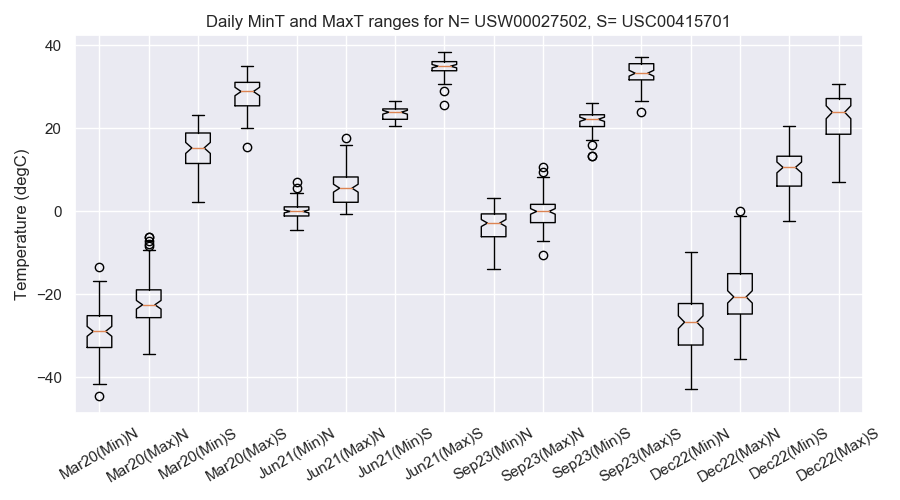

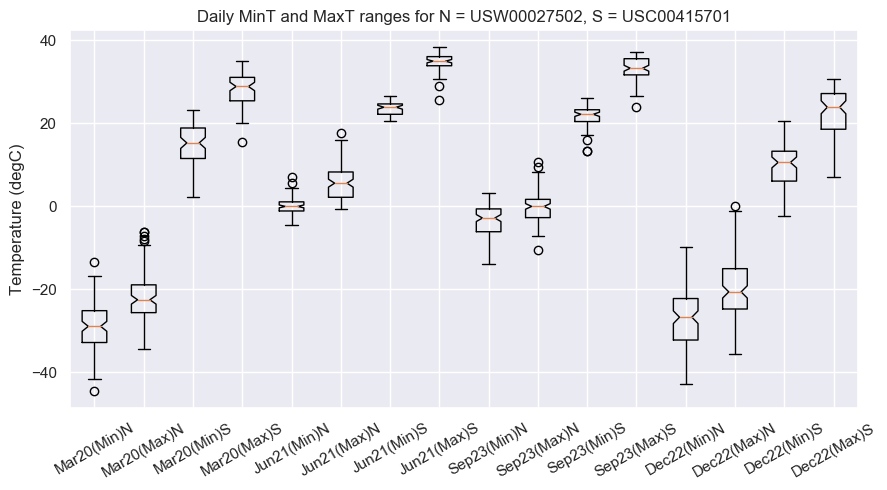

In [7]:
# Once again we'll use the solstices and equinoxes to check the spread on the temperatures.
# The data we need is in this dictionary. The key is the label we want on the x axis,
# and the value is the numpy array at the specified date.
dctCheckDays = {'Mar20(Min)N': srNWMinTemps[  3, 20], 'Mar20(Max)N': srNWMaxTemps[  3, 20], 
                'Mar20(Min)S': srSWMinTemps[  3, 20], 'Mar20(Max)S': srSWMaxTemps[  3, 20], 
                'Jun21(Min)N': srNWMinTemps[  6, 21], 'Jun21(Max)N': srNWMaxTemps[  6, 21],
                'Jun21(Min)S': srSWMinTemps[  6, 21], 'Jun21(Max)S': srSWMaxTemps[  6, 21],
                'Sep23(Min)N': srNWMinTemps[  9, 23], 'Sep23(Max)N': srNWMaxTemps[  9, 23],
                'Sep23(Min)S': srSWMinTemps[  9, 23], 'Sep23(Max)S': srSWMaxTemps[  9, 23],
                'Dec22(Min)N': srNWMinTemps[ 12, 22], 'Dec22(Max)N': srNWMaxTemps[ 12, 22],
                'Dec22(Min)S': srSWMinTemps[ 12, 22], 'Dec22(Max)S': srSWMaxTemps[ 12, 22] }
                
fig1 = plt.figure(num=1, figsize=[9,5], dpi=100, clear=True)
ax1 = plt.gca(title = 'Daily MinT and MaxT ranges for N = USW00027502, S = USC00415701')

labels, data = dctCheckDays.keys(), dctCheckDays.values()

plt.boxplot(data, notch=True)
plt.xticks(range(1, len(labels) + 1), labels,rotation = 30)
plt.ylabel('Temperature (degC)')
# This cleans up the figure and ensures that all text is within the boundaries.
fig1.tight_layout()

# This will save the file if you want to import the picture into a document.
# Please ensure this is commented out before submitting.
#plt.savefig('WeatherBox.png')


### Exercise 3
**(1.0 pts)**  
Histogram and density plots of the temperature data (on subplots).  
There are clearly some outliers and skewed mean values, so let's take a closer look at a the data distribution for September 23.  

The first function trims the data to just the inner quartile to eliminate outliers.
- You will want to keep data that is >= quantile(0.25) and <= quantile(0.75)
- Input is a numpy one dimensional array. output is a numpy array
- Hint - convert to a series and use quantile()

[Instructions](#Instructions)

In [8]:
def trim_inner_quartile( d ):
    new_series = pd.Series(d)
    first = new_series.quantile([0.25,0.75])
    new_series = new_series.to_numpy()
    new_series = [i for i in new_series if (i >=first[0.25]) and (i <=first[.75])]
    return (np.asarray(new_series))

In [9]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
d = dctCheckDays['Sep23(Min)S']
assert (76,) == d.shape
d = trim_inner_quartile(d)
assert (39,) == d.shape
assert isinstance(d, np.ndarray)

d = dctCheckDays['Mar20(Min)N']
assert (102,) == d.shape
d = trim_inner_quartile(d)
assert (53,) == d.shape



This function plots a single set of data. 
- The plot will be a histogram overlayed with a kernel density estimate (kde) and a normal distribution.
- Just use the seaborn distplot, to which you can pass a fit function.
- The inputs are specified in the function below. Call your trim function if qtrim==True

In [10]:
from scipy.stats import norm

def plot_hist_overlay( ax, data, label, qtrim=False):
    '''
    ax - axes on which to plot.
    data - list or numpy array that comprises the set of values to plot
    label - the name to associate with the data. It will be the x axis label
    qtrim - if True, only work with the inner quartile (.25, .75) when plotting and calculating the mean
            if False, then use all the data
    '''
    if qtrim == False:
        a = sns.distplot(data, ax = ax,fit = norm)
        ax.xaxis.set_label_text(label)
        
    else:
        sns.distplot(trim_inner_quartile(data), ax = ax,fit = norm)
        ax.xaxis.set_label_text(label)

Now create a 2 row by 4 column array of these plots. Put the northern station data on top, and the southern station data on the bottom row. Each group of 4 graphs will be the min then max temps for the two equinox days. Use subplots() and make sure all plots share the x and y axis. The result will look like this:
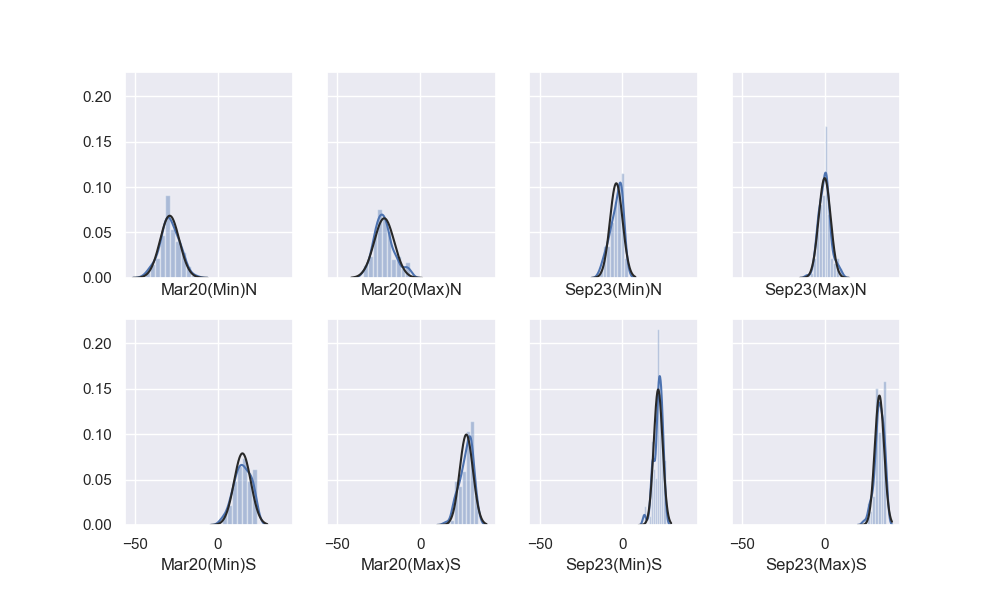

[Instructions](#Instructions)

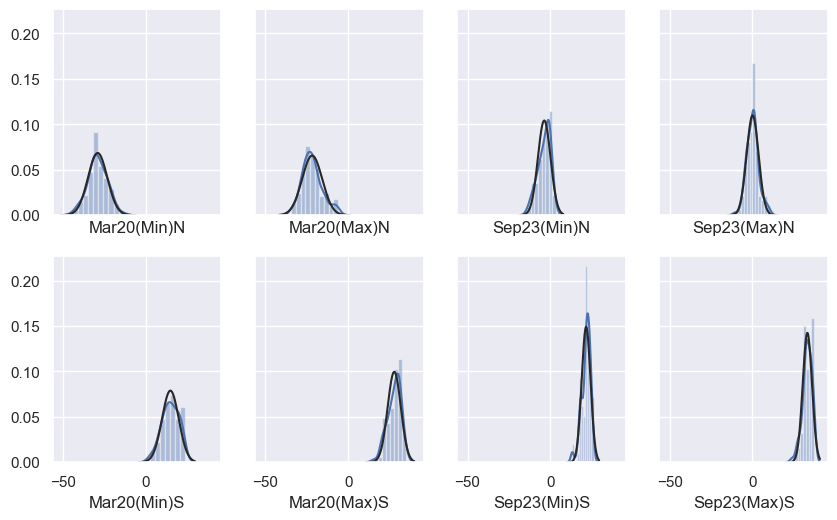

In [11]:
# Create two by two array of plots with North min/max on top and South min/max on bottom
# Use figsize=[10,6], dpi=100,

fig2, axs2 = plt.subplots(num=2, nrows=2, ncols=4, sharey=True, sharex=True, figsize=[10,6], dpi=100, clear=True)

plot_hist_overlay(ax=axs2[0, 0],data = srNWMinTemps[  3, 20],label = 'Mar20(Min)N')
plot_hist_overlay(ax=axs2[0, 1],data = srNWMaxTemps[  3, 20],label = 'Mar20(Max)N')
plot_hist_overlay(ax=axs2[0, 2],data = srNWMinTemps[  9, 23],label = 'Sep23(Min)N')
plot_hist_overlay(ax=axs2[0, 3],data = srNWMaxTemps[  9, 23],label = 'Sep23(Max)N')
plot_hist_overlay(ax=axs2[1, 0],data = srSWMinTemps[  3, 20],label = 'Mar20(Min)S')
plot_hist_overlay(ax=axs2[1, 1],data = srSWMaxTemps[  3, 20],label = 'Mar20(Max)S')
plot_hist_overlay(ax=axs2[1, 2],data = srSWMinTemps[  9, 23],label = 'Sep23(Min)S')
plot_hist_overlay(ax=axs2[1, 3],data = srSWMaxTemps[  9, 23],label = 'Sep23(Max)S')


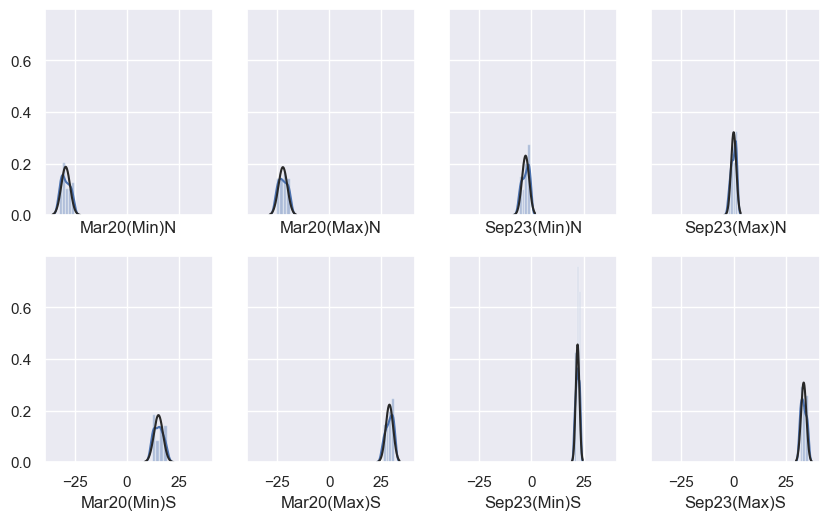

In [12]:
# Draw the same plot only using the inner quartile of the data
fig3, axs3 = plt.subplots(num=3, nrows=2, ncols=4, sharey=True, sharex=True, figsize=[10,6], dpi=100, clear=True)
plot_hist_overlay(ax=axs3[0, 0],data = srNWMinTemps[  3, 20],label = 'Mar20(Min)N',qtrim = True)
plot_hist_overlay(ax=axs3[0, 1],data = srNWMaxTemps[  3, 20],label = 'Mar20(Max)N',qtrim = True)
plot_hist_overlay(ax=axs3[0, 2],data = srNWMinTemps[  9, 23],label = 'Sep23(Min)N',qtrim = True)
plot_hist_overlay(ax=axs3[0, 3],data = srNWMaxTemps[  9, 23],label = 'Sep23(Max)N',qtrim = True)
plot_hist_overlay(ax=axs3[1, 0],data = srSWMinTemps[  3, 20],label = 'Mar20(Min)S',qtrim = True)
plot_hist_overlay(ax=axs3[1, 1],data = srSWMaxTemps[  3, 20],label = 'Mar20(Max)S',qtrim = True)
plot_hist_overlay(ax=axs3[1, 2],data = srSWMinTemps[  9, 23],label = 'Sep23(Min)S',qtrim = True)
plot_hist_overlay(ax=axs3[1, 3],data = srSWMaxTemps[  9, 23],label = 'Sep23(Max)S',qtrim = True)

### Exercise 4
**(1.0 pts)**  
Preparing the data

For our quality graphic, we want to put several lines on a chart simultaneously.
_X axis_
- Will be one year. 
- To make data prep and plot easier, we'll create each of our arrays with a DOY index of 0 to 364. 
- On the plot, we'll change the labels to be month names with minor ticks for days.
_Y axis_
- Top line will be the maximum high temperature found in the data for each day
- The first middle line will be the average of all high and low temperatures for each day
- The second middle line will be our solar power line
- The bottom line will be the minimum low temperature found in the data for each day

The mean of the inner quartile is going to be still pretty rough, but to get a smoother fit, we'll have to wait until we can run some regression analysis. 


[Instructions](#Instructions)

#### Preparing the Temperatures
The following function will help prepare the average temperature and the solar data. 
- input is a series with a multi-index (Month, Day) index, and a numpy array of data in each value position
- change the index to a single Day Of Year (DOY) numbered from 0 to 364
- Replace the array of values for each day with the mean of the inner quartile (use your trim_inner_quartile function). 

In [13]:
from statistics import mean 
def trim_to_iq_mean(sr):
    '''
    The input is expected to be a series with a multiple level index (Month, Day), where the value for each
    day is a numpy array. The output is a series with the same name, but with a Day of Year index and the
    values being the mean of the inner quartile for that day.
    '''
    sr.reset_index(drop = True,inplace = True)
    tmp = sr.name
    sr = [mean(trim_inner_quartile(val)) for val in sr.tolist()]
    sr = pd.Series(sr,name = tmp)
    sr.index.name = 'DOY'
    print((sr))
    return sr

In [14]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
srNWMinT = trim_to_iq_mean(srNWMinTemps)
srNWMaxT = trim_to_iq_mean(srNWMaxTemps)
srSWMinT = trim_to_iq_mean(srSWMinTemps)
srSWMaxT = trim_to_iq_mean(srSWMaxTemps)

np.testing.assert_almost_equal(srNWMinT[0], -28.1, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srNWMinT[128], -11.7, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSWMinT[128], 22.1, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSWMinT[364], 9.9, decimal=1, err_msg='Incorrect mean', verbose=True)

assert 'DOY' == srNWMinT.index.name
assert 'MinTemp(degC)' == srNWMinT.name
                          


DOY
0     -28.114545
1     -28.190385
2     -28.883929
3     -29.077193
4     -28.729630
         ...    
360   -28.400000
361   -27.445614
362   -28.055556
363   -28.079245
364   -28.351786
Name: MinTemp(degC), Length: 365, dtype: float64
DOY
0     -21.394444
1     -22.049091
2     -22.826923
3     -22.450943
4     -22.479245
         ...    
360   -21.022414
361   -21.756364
362   -21.081132
363   -21.864815
364   -22.012281
Name: MaxTemp(degC), Length: 365, dtype: float64
DOY
0       8.978049
1       7.994737
2       7.916279
3       8.120000
4       7.795000
         ...    
360     8.140476
361     8.575000
362     9.110000
363    10.190698
364     9.865000
Name: MinTemp(degC), Length: 365, dtype: float64
DOY
0      23.569048
1      20.967568
2      20.925000
3      19.624324
4      20.089474
         ...    
360    21.310811
361    21.570732
362    21.902564
363    21.748780
364    22.335000
Name: MaxTemp(degC), Length: 365, dtype: float64


Next we need a function to convert the Average Max temperature and Average Min temperature to just a daily average (mean of the min and max). Since we are eventually going to scale both temperature and solar radiation values, the units won't matter for our final graphic, so we'll give it a name that will be appropriate later.
- Input is two series, each with DOY index.
- Output is a single series with a DOY index.
- The new series must be named 'Daily Mean Temp.'

In [15]:
def avg_from_min_max( srMin, srMax ):
    sr_new = pd.concat([srMin, srMax], axis=1)
    sr_new.index.name = 'DOY'
    sr_new['Daily Mean Temp.'] = sr_new.mean(axis = 1)
    return (sr_new['Daily Mean Temp.'])

In [16]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
srNAvgT = avg_from_min_max( srNWMinT, srNWMaxT)
srSAvgT = avg_from_min_max( srSWMinT, srSWMaxT)

np.testing.assert_almost_equal(srNAvgT[364], -25.2, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srNAvgT[128], -8.55, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSAvgT[128], 27.1, decimal=1, err_msg='Incorrect mean', verbose=True)

assert 'Daily Mean Temp.' == srNAvgT.name

np.testing.assert_almost_equal(srSAvgT.min(), 13.9, decimal=1, err_msg='Incorrect mean', verbose=True)


Finally, we need a function to find the outer envelopes for the temperature data
- input is a series with a multi-index (Month, Day) index, and a numpy array of data in each value position
- change the index to a single Day Of Year (DOY) numbered from 0 to 364
- Replace the array of values for each day with either the minimum or maximum value, depending on the bMax flag.
- Make sure the name is based on the flag:  'Record High Temp.' or 'Record Low Temp.'


In [17]:
def envelope_temp( sr, bMax=True ):
    sr.reset_index(drop = True,inplace = True)
    sr_new = []
    for i in sr.to_list():
        if bMax == True:
            sr_new.append(max(i))
            tmp = 'Record High Temp.'
        else:
            sr_new.append(min(i))
            tmp = 'Record Low Temp.'
    sr_new = pd.Series(sr_new,name = tmp)
    sr.index.name = 'DOY'
    return (sr_new)

In [18]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

srNRecLT = envelope_temp(srNWMinTemps, False)
srNRecHT = envelope_temp(srNWMaxTemps, True)
srSRecLT = envelope_temp(srSWMinTemps, False)
srSRecHT = envelope_temp(srSWMaxTemps, True)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
np.testing.assert_almost_equal(srNRecLT[364], -46.1, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srNRecLT[4], -45.6, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srNRecHT[128], 2.2, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSRecHT[128], 36.7, decimal=1, err_msg='Incorrect mean', verbose=True)

assert 'Record Low Temp.' == srNRecLT.name

np.testing.assert_almost_equal(srNRecLT.min(), -48.9, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSRecHT.max(), 50.0, decimal=1, err_msg='Incorrect mean', verbose=True)


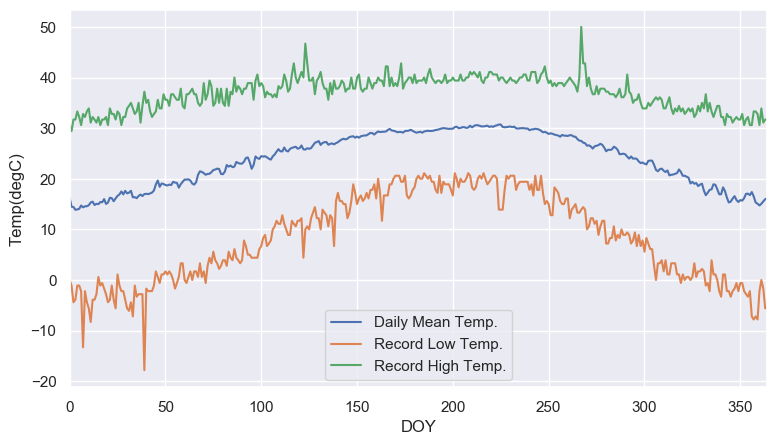

In [19]:
# Do a quick and dirty plot of the Southern temperatures all on the same graph just to see how the data looks. 
# Colors don't matter here.
# The X axis must be labeled 'DOY'
# The Legend must have labels based on the series name
# Y axis lable must be 'Temp(degC)'
# Use srSAvgT, srSRecLT, srSRecHT

fig4 = plt.figure(num=4, figsize=[9,5], dpi=100, clear=True)
srSAvgT.plot(legend = True)
srSRecLT.plot(legend = True)
srSRecHT.plot(legend = True)
plt.ylabel('Temp(degC)')
plt.show()

#### Prepare the solar data
Now to prepare the solar data. The next function must
- Take as input the dataframe containing the solar data for a station
- Return a series indexed by DOY
- The value for each day is the mean of the sum of all the hours for that day
- Change the name of the series to 'Daily Solar Energy'


In [20]:
def solar_trim_to_mean_year( dfSolarData ):
    dfSolarData = dfSolarData.drop(dfSolarData[(dfSolarData['Month'] == 2) & (dfSolarData['Day'] == 29)].index)
    dfSolarData= dfSolarData.groupby(['Month','Day'])['GloMod_Wpm2'].mean()
    ds = dfSolarData
    ds.reset_index(drop = True,inplace = True)
    ds.index.name = 'DOY'
    ds.name = 'Daily Solar Energy'
    return (ds)


In [21]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
srNRads = solar_trim_to_mean_year(dfSolarNorthData)
srSRads = solar_trim_to_mean_year(dfSolarSouthData)

assert 'DOY' == srSRads.index.name
assert 'Daily Solar Energy' == srSRads.name
np.testing.assert_almost_equal(srNRads[128], 3256, decimal=0, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srNRads[364],    0, decimal=1, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSRads[0],   2476, decimal=0, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSRads[128], 5354, decimal=0, err_msg='Incorrect mean', verbose=True)

np.testing.assert_almost_equal(srNRads.min(), 0,     decimal=0, err_msg='Incorrect mean', verbose=True)
np.testing.assert_almost_equal(srSRads.max(), 7232,  decimal=0, err_msg='Incorrect mean', verbose=True)



### Exercise 5
**(0.5 pts)**  
Scaling the data

Since the range values for temperature and solar radiation are very dissimilar, we'll need to do some scaling to put them both on the same chart. We are going to draw separate graphs for the north and south regions, but we want the relative scales to match.

The northern chart will include data from 
- srSRecLT, srSAvgT, srSRecHT, srSRads  
The southern chart will include data from
- srNRecLT, srNAvgT, srNRecHT, srNRads  

First, we need a function to do scaling. The general formula for scaling a value $y_i$ with range $(Y_{min}, Y_{max})$ to a new scale with range $(Z_{min}, Z_{max})$ is:

$$y_{iScaled} = \frac{y_i-Y_{min}}{Y_{max}-Y_{min}}*(Z_{max}-Z_{min})+Z_{min}$$


[Instructions](#Instructions)

In [22]:
def rescale( y, YLim, ZLim ):
    '''
    y is the value to rescale. This should work with a single value, a series, or a numpy array
    YLIM is a tuple of (min, max)
    ZLIM is a tuple of (min, max)
    Returns the scaled value(s) in the same type as the input.
    '''
    ymin = YLim[0]
    ymax = YLim[1]
    zmin = ZLim[0]
    zmax = ZLim[1]
    if isinstance(y, pd.Series):
        tmp = y.name
        y = y.to_list()
        y = [((i-ymin)/(ymax-ymin)*(zmax-zmin))+zmin for i in y]
        y = pd.Series(y,name = tmp)
    elif isinstance(y, np.ndarray):
        y = list(y)
        y = [((i-ymin)/(ymax-ymin)*(zmax-zmin))+zmin for i in y]
        y = np.asarray(y)
    else:
        y = ((y-ymin)/(ymax-ymin)*(zmax-zmin))+zmin
    return y        

In [23]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

YLim = (5, 10)
ZLim = (-1, 1)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
y = pd.Series(data=[5, 6, 8, 10])
np.testing.assert_almost_equal(rescale(y, YLim, ZLim ).values, [-1.0, -0.6, 0.2, 1.0], decimal=1, err_msg='Incorrect scale', verbose=True)

y = np.array([5, 6, 8, 10])
np.testing.assert_almost_equal(rescale(y, YLim, ZLim ), [-1.0, -0.6, 0.2, 1.0], decimal=1, err_msg='Incorrect scale', verbose=True)
    

Now a general data formatting function for our plot 
- The first four inputs will be four series in the order shown
- The next input is the overall temperature range (both N & S) as a tuple (Tmin, Tmax)
- The next input is the range associated with the average temperatures (both N & S) (TAvgMin, TAvgMax)
- The last input is the range associated with the solar radiation (both N&S) (Smin, Smax)
- output will be a single dataframe
- df index will be DOY
- Each column will be the name of the series that was placed in the column
- The values will be scaled as follows:
    - Scale all of the temperatures between 0 and 1 using the overall temperature range
    - Use the average temperature range and the solar radiation range to scale the solar data so that the scaled maximum solar value is the same as the scaled maximum average temperature, and the scaled minimum solar value is the same as the scaled minimum average temperature.

In [24]:
def scale_for_chart( srRecLT, srAvgT, srRecHT, srRads, TLim, TALim, SLim):
    srRecLT = rescale(srRecLT,TLim,[0,1])
    srAvgT = rescale(srAvgT,TLim,[0,1])
    srRecHT = rescale(srRecHT,TLim,[0,1])
    srRads = rescale(srRads,SLim,[srAvgT.min(),srAvgT.max()])
    df = pd.concat([srRecLT, srAvgT, srRecHT, srRads], axis=1)
    #print(df)
    df.index.name = 'DOY'
    return (df)

In [25]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
TLim  = (srNRecLT.min(), srSRecHT.max())
TALim = ( min(srNAvgT.min(), srSAvgT.min()), max(srNAvgT.max(), srSAvgT.max()))
SLim  = ( min(srNRads.min(), srSRads.min()), max(srNRads.max(), srSRads.max()))

cols = ['Record Low Temp.', 'Daily Mean Temp.', 'Record High Temp.', 'Daily Solar Energy']

dfN = scale_for_chart( srNRecLT, srNAvgT, srNRecHT, srNRads, TLim, TALim, SLim )                          
dfS = scale_for_chart( srSRecLT, srSAvgT, srSRecHT, srSRads, TLim, TALim, SLim )  

np.testing.assert_almost_equal(dfN[cols[0]].min(), 0.0, decimal=1, err_msg='Incorrect scale', verbose=True)
np.testing.assert_almost_equal(dfS[cols[2]].max(), 1.0, decimal=1, err_msg='Incorrect scale', verbose=True)

np.testing.assert_almost_equal(dfN[cols[3]].min(), dfN[cols[1]].min(), decimal=1, err_msg='Incorrect scale', verbose=True)
np.testing.assert_almost_equal(dfS[cols[3]].max(), dfS[cols[1]].max(), decimal=1, err_msg='Incorrect scale', verbose=True)



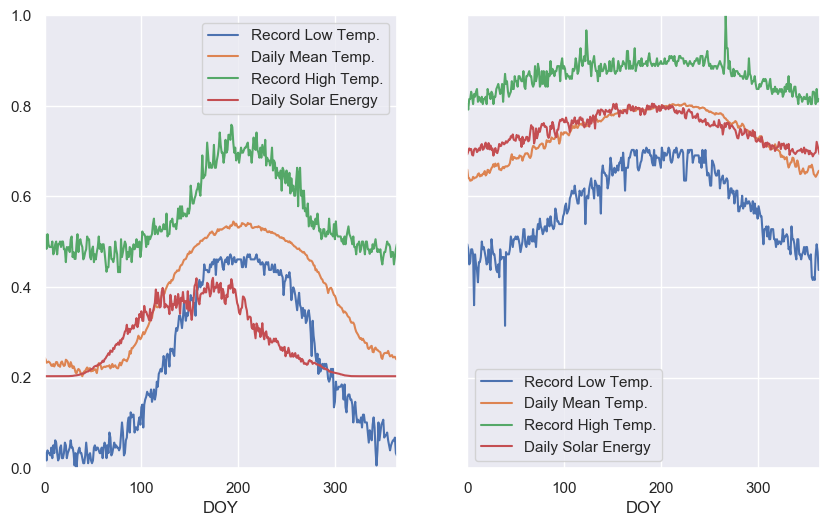

In [26]:
# Quick plot of the data to ensure we are scaling ok.
fig5, axs5 = plt.subplots(num=5, nrows=1, ncols=2, sharey=True, figsize=[10,6], dpi=100, clear=True)
dfN.plot.line(ax=axs5[0], ylim=(0,1))
dfS.plot.line(ax=axs5[1])

### Exercise 6
**(1.5 pts)**  
Quality plots of combined temperature and solar radiation

Now it is time to draw a chart that helps convey the relationship between solar radiation and temperature across an annual cycle. The function below must draw a chart given dfN or dfS. Start by using the plot style 'seaborn-whitegrid'. The points are allocated as follows:

| Points | Graph Feature |
|:----:|:-------------|
| .2 | Plot the record low in blue, record high in red, both with alpha 0.5. Plot the mean in black, alpha .3, and the solar in gold #FFD700, alpha 1.0 |
| .2 | Fill the space between the temperature lines with red and blue with alpha 0.05 |
| .2 | Remove the top, right, and left spines |
| .2 | Set the y limits to (0,1) and remove the tick labels |
| .2 | Label the x axis (fontsize 12) and put date labels on the x axis, rotated by 70 degrees, labelsize 10 |
| .2 | Tone down the x,y grid with an alpha of 0.3 |
| .1 | Put the legend in the bottom middle, fontsize 10 |
| .2 | Title the graph including the weather station name and state, font size 14 |


The final graph for the northern station should look like this:
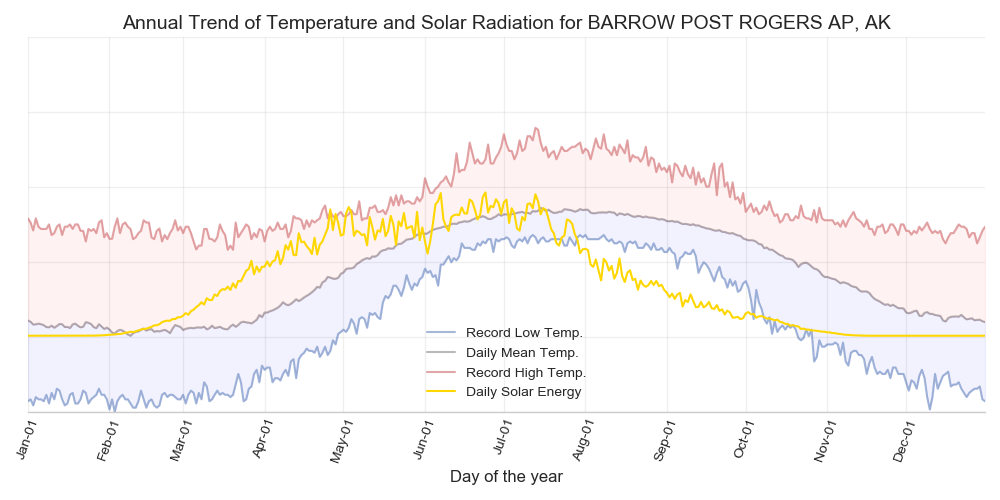


[Instructions](#Instructions)

In [32]:
def draw_solar_temperature_chart( df, idWeatherStation ):
    sns.lineplot(data = df['Record Low Temp.'],color='blue', alpha=0.5, label='Record Low Temp.')
    sns.lineplot(data = df['Record High Temp.'],color='red',  alpha=0.5, label='Record High Temp.')
    plt.fill_between(np.arange(0,365),df['Record High Temp.'],df['Daily Mean Temp.'],facecolor='red',alpha = 0.05)
    plt.fill_between(np.arange(0,365),df['Record Low Temp.'],df['Daily Mean Temp.'],facecolor='blue',alpha = 0.05)
    sns.lineplot(data = df['Daily Mean Temp.'],color='black',  alpha=0.3, label='Daily Mean Temp.')
    sns.lineplot(data = df['Daily Solar Energy'],color='gold',  alpha=1.0, label='Daily Solar Energy')
    sns.despine(top=True, right=True, left=True)
    plt.yticks(np.arange(0, 1,0.2),[])
    plt.margins(x=0)
    plt.xlabel('Day of the Year',fontsize = 12)
    plt.xticks(np.arange(0, 350,30),['Jan-01','Feb-01','Mar-01','Apr-01','May-01','Jun-01','Jul-01','Aug-01','Sep-01','Oct-01','Nov-01','Dec-01'],fontsize = 10,rotation = 70)
    plt.grid(alpha = 0.3)
    plt.legend(loc='lower center',fontsize = 10,frameon=False)
    plt.title('Annual Trend of Temperature and Solar Radiation for '+ghcn.get_station_info(idWeatherStation)['StationName']+ ', ' +ghcn.get_station_info(idWeatherStation)['State'], fontsize = 14)
    #sns.set_style("whitegrid")
    plt.style.use('seaborn-whitegrid')

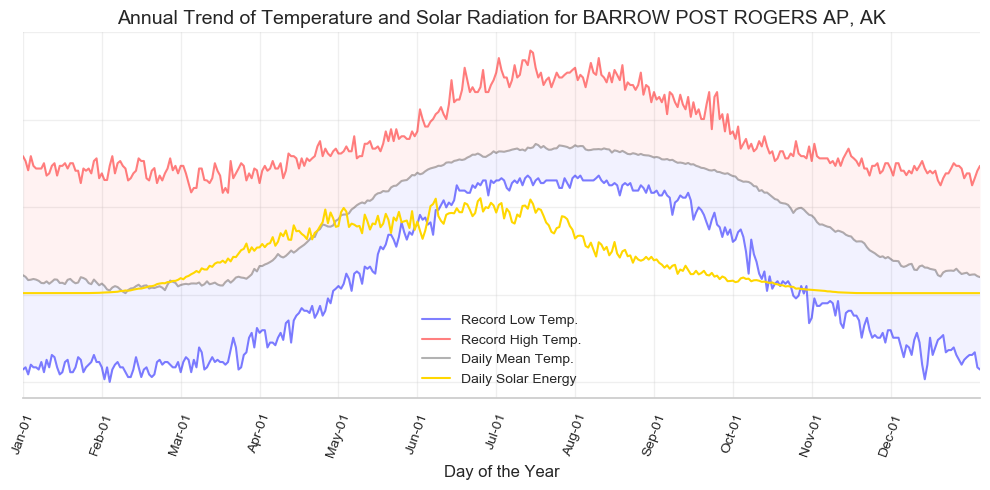

In [33]:
fig6 = plt.figure(num=6, figsize=[10,5], dpi=100, clear=True)
draw_solar_temperature_chart( dfN, idWeatherNorth )
fig6.tight_layout()


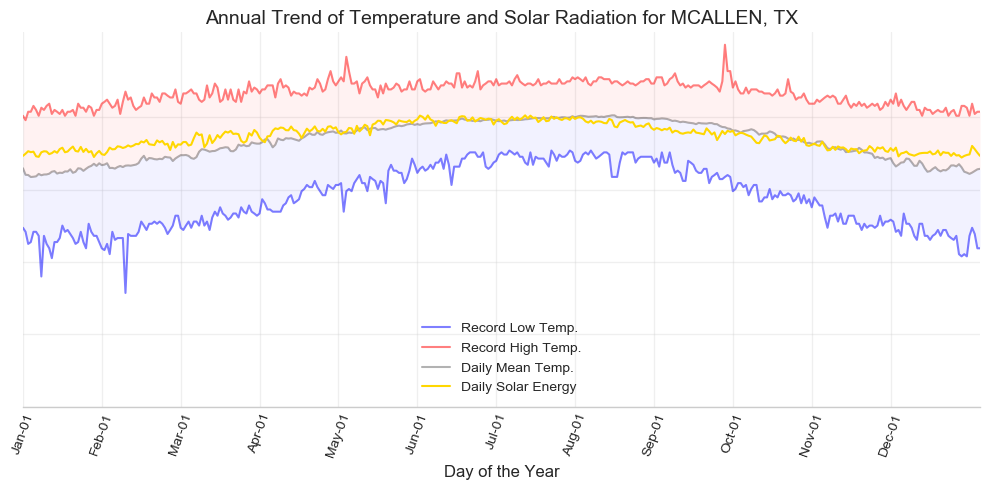

In [34]:
# And for the southern station
fig7 = plt.figure(num=7, figsize=[10,5], dpi=100, clear=True)
draw_solar_temperature_chart( dfS, idWeatherSouth )
fig7.tight_layout()

## References

1. Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.  

2. [Solar Radiation Measurements Workshop](https://www.nrel.gov/docs/gen/fy04/36831p.pdf), National Renewable Energy Laboratory, Aug. 2004.  

3. Stoffel, Tom, [State of the Practice for Diffuse Solar Irradiance Measurements](https://www.nrel.gov/pv/assets/pdfs/2015_pvmrw_171_stoffel.pdf), Feb. 2015.  